In [1]:
from IPython.display import display, HTML

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from transformer import TransformerConfig
from lm import LM

In [2]:
# chargement des données
fichier = open('villes.txt')
donnees = fichier.read()
villes = donnees.replace('\n', ',').split(',')
villes = [ville for ville in villes if len(ville) > 2]

In [3]:
# création du vocabulaire

vocabulaire = sorted(list(set(''.join(villes))))
vocabulaire = ["<pad>", "<SOS>", "<EOS>"] + vocabulaire
# <SOS> et <EOS> sont ajoutés respectivement au début et à la fin de chaque séquence
# <pad> est utilisé pour faire en sorte que toutes les séquences aient la même longueur

# pour convertir char <-> int
char_to_int = {}
int_to_char = {}

for (c, i) in zip(vocabulaire, range(len(vocabulaire))):
    char_to_int[c] = i
    int_to_char[i] = c

In [4]:
num_sequences = len(villes)
max_len = max([len(ville) for ville in villes]) + 2 # <SOS> et <EOS>

X = torch.zeros((num_sequences, max_len), dtype=torch.int32)

for i in range(num_sequences):
    X[i] = torch.tensor([char_to_int['<SOS>']] + [char_to_int[c] for c in villes[i]] + [char_to_int['<EOS>']] + [char_to_int['<pad>']] * (max_len - len(villes[i]) - 2))

n_split = int(0.9*X.shape[0])

idx_permut = torch.randperm(X.shape[0])
idx_train, _ = torch.sort(idx_permut[:n_split])
idx_val, _ = torch.sort(idx_permut[n_split:])

X_train = X[idx_train]
X_val = X[idx_val]

In [5]:
def get_batch(split, batch_size):
    data = X_train if split == 'train' else X_val

    idx_seed = torch.randint(low=int(batch_size/2), high=int(data.shape[0]-batch_size/2), size=(1,), dtype=torch.int32).item()

    batch = data[int(idx_seed-batch_size/2):int(idx_seed+batch_size/2)]
    X = batch[:, :-1] # (B, L=max_len-1=46)
    Y = batch[:, 1:] # (B, L)
    return X, Y.long()

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self, act_size, d_hidden, l1_coeff):
        super().__init__()

        self.l1_coeff = l1_coeff

        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(act_size, d_hidden)))
        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_hidden, act_size)))
        self.b_enc = nn.Parameter(torch.zeros(d_hidden))
        self.b_dec = nn.Parameter(torch.zeros(act_size))

        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
    
    def forward(self, x):
        x_cent = x - self.b_dec
        acts = F.relu(x_cent @ self.W_enc + self.b_enc)
        x_reconstruct = acts @ self.W_dec + self.b_dec
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0)
        l1_loss = self.l1_coeff * (acts.float().abs().sum())
        loss = l2_loss + l1_loss
        return loss, x_reconstruct, acts, l2_loss, l1_loss
    
    @torch.no_grad()
    def make_decoder_weights_and_grad_unit_norm(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj
        # Bugfix(?) for ensuring W_dec retains unit norm, this was not there when I trained my original autoencoders.
        self.W_dec.data = W_dec_normed

In [68]:
config = TransformerConfig(d_model=128, n_layers=1, n_heads=4, max_len=max_len, dropout=0.)
model = LM(config, vocab_size=len(vocabulaire))
model.load_state_dict(torch.load("transformer.pth"))

sae = AutoEncoder(act_size=config.d_model, d_hidden=2*128, l1_coeff=3e-4) # 3e-4 marche bien
optim = torch.optim.Adam(sae.parameters(), lr=3e-4) # 3e-4 marche bien

In [78]:
for i in range(1000):
    X, Y = get_batch('train', 16) # (B, L)

    act = model(X, act=True).view(-1, config.d_model) # (B*L, 128)

    loss, x_reconstruct, features, l2_loss, l1_loss = sae(act)
    loss.backward()
    sae.make_decoder_weights_and_grad_unit_norm()
    optim.step()
    optim.zero_grad()
    
    if i%100==0:
        print(f"loss : {loss.item()}")

# features freq
X, Y = get_batch('val', 512) # (B, L)
act = model(X, act=True).view(-1, config.d_model)
_, _, features, _, _ = sae(act)

print(f"frac of features with freq < 1/100 : {((((features>0).int()).sum(0) / features.shape[0]) < 1e-2).float().mean()}")
print(f"frac of features with freq < 1/1,000 : {((((features>0).int()).sum(0) / features.shape[0]) < 1e-3).float().mean()}")
print(f"frac of features with freq < 1/10,000 : {((((features>0).int()).sum(0) / features.shape[0]) < 1e-4).float().mean()}")

loss : 1.0187360048294067


In [70]:
# feature and act reconstruction viz

X, Y = get_batch('train', 1) # (B, L)
act = model(X, act=True).view(-1, config.d_model) # (B, L, d_model)
_, act_recon, features, _, _ = sae(act)

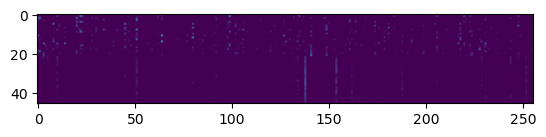

In [71]:
plt.imshow(features.detach())

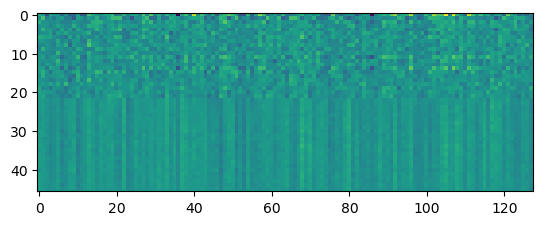

In [72]:
plt.imshow(act.detach())

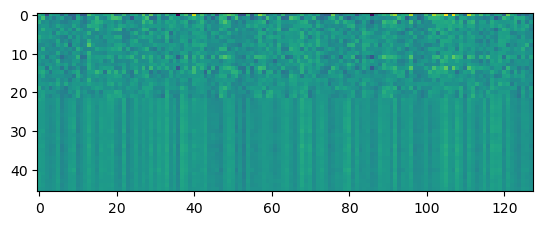

In [73]:
plt.imshow(act_recon.detach())

In [77]:
X, Y = get_batch('val', 16) # (B, L)
act = model(X, act=True).view(-1, config.d_model)
_, act_recon, features, _, _ = sae(act)

x = model.out_norm(act_recon)
logits = model.lm_head(x)

loss = F.cross_entropy(logits.view(-1, logits.size(-1)), Y.view(-1), ignore_index=char_to_int['<pad>'])
print(f"reconstruction loss : {loss.item():.2f}")

reconstruction loss : 1.97


In [137]:
# model loss : 1.75

### neurones interprétables ?

In [23]:
top_k = 20
batch_size = 16

In [24]:
def update_top_k(top_values, top_indices, new_values, new_indices, k=20):
    combined_values = torch.cat([top_values, new_values])
    combined_indices = torch.cat([top_indices, new_indices])
    
    new_top_values, topk_indices = torch.topk(combined_values, k)
    new_top_indices = combined_indices[topk_indices]
    
    return new_top_values, new_top_indices

In [25]:
top_values = torch.full((config.d_model, top_k), -float('inf'))
top_indices = torch.full((config.d_model, top_k), -1, dtype=torch.long)

for i in range(0, X_train.shape[0], batch_size):
    X = X_train[i:i+batch_size]
    act = model(X, act=True) # (B, L, 128)
    max_act = act.max(dim=1).values # (B, 128)

    for dim in range(config.d_model):
        dim_values = max_act[:, dim]
        dim_indices = i + torch.arange(batch_size)

        top_values[dim], top_indices[dim] = update_top_k(top_values[dim], top_indices[dim], dim_values, dim_indices)

In [25]:
for i in top_indices[64]:
    print("".join([int_to_char[k] for k in [p.item() for p in X_train[i.item()] if p.item() != 0] if k != 1 and k != 2]))

# 58 = saint

éleu-dit-leauwette
pécharic-et-le-py
le collet-de-dèze
luxémont-et-villotte
poiseul-la-ville-et-laperrière
cauchy-à-la-tour
pointe-à-pitre
bout-du-pont-de-larn
merkwiller-pechelbronn
mareil-sur-mauldre
brandonnet
saint-sulpice
valencogne
fessevillers
trémentines
frain
bessenay
calorguen
agnières
manot


### features interprétables ?

In [14]:
top_k = 20
batch_size = 64

In [15]:
def update_top_k(top_values, top_indices, new_values, new_indices, k=20):
    combined_values = torch.cat([top_values, new_values])
    combined_indices = torch.cat([top_indices, new_indices])
    
    new_top_values, topk_indices = torch.topk(combined_values, k)
    new_top_indices = combined_indices[topk_indices]
    
    return new_top_values, new_top_indices

In [16]:
top_values = torch.full((config.d_model, top_k), -float('inf'))
top_indices = torch.full((config.d_model, top_k), -1, dtype=torch.long)

for i in range(0, X_train.shape[0], batch_size):
    X = X_train[i:i+batch_size]
    act = model(X, act=True) # (B, L, 128)
    _, _, features, _, _ = sae(act)
    max_features = features.max(dim=1).values # (B, 128)

    for dim in range(config.d_model):
        dim_values = max_features[:, dim]
        dim_indices = i + torch.arange(batch_size)

        top_values[dim], top_indices[dim] = update_top_k(top_values[dim], top_indices[dim], dim_values, dim_indices)

In [67]:
feature = 67
for i in top_indices[feature]:
    ville = "".join([int_to_char[k] for k in [p.item() for p in X_train[i.item()] if p.item() != 0] if k != 1 and k != 2])
    act = model(X_train[i.item()].unsqueeze(0), act=True) # (B, L, 128)
    _, _, features, _, _ = sae(act)

    print_colore(ville, features[0, :, feature].tolist()[:len(ville)])

# 7 = saint mais pas au début
# 8 = saint
# 9 = présence de "ch"

In [39]:
def print_colore(text, values):
    assert len(text) == len(values)

    def valeur_en_nuance_rouge(value):
        red_intensity = int(value * 255)
        return f'rgb({red_intensity}, 0, 0)'

    html_text = ''.join([f'<span style="background-color:{valeur_en_nuance_rouge(values[i % len(values)])}">{char}</span>' for i, char in enumerate(text)])
    display(HTML(html_text))

In [279]:
text = "Hello, World!"
values = [0.0, 0.1, 0.9, 0.9, 0., 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.5, 0.3]
print_colore(text, values)